I'll start with creating some simple frequency-based baseline models, i.e., <i>BOW</i> and <i>TF-IDF</i>.  In later notebooks, I'll improve on these models

<h2>Load and split the data</h2>

Let's load our cleaned data first

In [1]:
import pandas as pd

train = pd.read_csv('data/train_cleaned.csv')
test = pd.read_csv('data/test_cleaned.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (7613, 8)
Test shape: (3263, 5)


In [2]:
train.head()

,id,keyword,location,text,target,clean_text,num_words,num_characters
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,13,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,22,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,9,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,17,88


In [3]:
test.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train['clean_text'], train['target'], shuffle=True, test_size=0.2, random_state=0)

<h2>Bag on N-grams</h2>

I'll implement BOW using `CountVectorizer` from `sklearn`. This is pretty straight-forward -- just count the occurrence of each ngram in the corpus. I'll use unigrams and bigrams here.  We don't have that much data and trigrams are likely to just add noise

<b>Train the Bag of N-grams model</b>

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(max_features=50000, ngram_range=(1, 2))
train_data_features = bv.fit_transform(X_train)
val_data_features = bv.transform(X_val)

In [6]:
vocab = bv.get_feature_names()
print(vocab[:10])

['aa', 'aa ayyo', 'aa batteries', 'aaaa', 'aaaa ok', 'aaaaaand', 'aaaaaand thunder', 'aal', 'aar', 'aar ambulance']


<h2>Naive Bayes</h2>

Refer to Jeremy Howard's lecture: https://www.youtube.com/watch?v=37sFIak42Sc&feature=youtu.be&t=3745

Naive Bayes theorem is an extension of <b>Bayes' Theorem</b>, which can be defined as <i>the probability of an event occurring given the probability of another event that has already occurred</i>. It can be mathematically stated as: 

$P(A|B) = \frac{\text{P(B|A)P(A)}}{\text{P(B)}}$

- The idea is to find P(A) given the probability of event B
- P(A) is <i>a priori</i> probability of event A, i.e., prior to seeing new evidence B. 
- P(A|B) is the <i>a posteriori</i> probability of A conditional upon event B occurring. 

In our case, it can be generalized to: what is the probability of a certain tweet being a disaster tweet, i.e., classification of 1, given a collection of tokens in that tweet?  

<h4>Naive Assumption</h4>

This assumption states that all the features must be <i>independent</i> of each other.  This is definitely not realistic in most real-life scenarios, but it is a good starting point for a theoretical model.  For example, we know and can assert definitively, that the words in a sentence are not independent of each other.  That's the whole idea behind CBOW and SkipGram models that words aren't independent of each other and we can predict them based on context. 

We define the <b>log-count ratio</b>, <i>r</i>, for each word <i>f</i>:

$r = \log \frac{\text{ratio of feature $f$ in disaster tweets}}{\text{ratio of feature $f$ in non-disaster tweets}}$

where ratio of feature, <i>f</i>, in disaster tweets is the number of times a disaster tweet has a feature divided by the number of disaster tweets

In [7]:
# Calculate the ratio of feature f
def pr(y_i):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [9]:
import numpy as np

x = train_data_features # these are simply counts of unigrams and bigrams as a sparse matrix
y = y_train.values # targets

r = np.log(pr(1)/pr(0)) # probability matrix for each feature based on the training set
b = np.log((y==1).mean() / (y==0).mean()) # bias

In [10]:
r.shape, r

((1, 50000), matrix([[ 0.27151798,  0.96466516, -0.4216292 , ..., -0.4216292 ,
          -0.4216292 , -0.4216292 ]]))

Apply the ratio <i>r</i> to the <b>Naive Bayes formula</b> and get predictions on the validation set

In [11]:
y_val_pre_preds = val_data_features @ r.T + b # multiply the probability matrix with the features in the validation set
y_val_preds = y_val_pre_preds.T > 0 # get disaster tweet predictions
(y_val_preds == y_val.values).mean() # estimate accuracy

0.7898883782009193

Now let's try <b>Binarized Naive Bayes</b>, which disregards the frequency of a token and simply assigns 1, if it is present and 0 if it is not. 

In [12]:
x = train_data_features.sign() # binarize
r = np.log(pr(1)/pr(0))

y_val_pre_preds = val_data_features.sign() @ r.T + b 
y_val_preds = y_val_pre_preds.T>0
(y_val_preds == y_val.values).mean()

0.7846355876559422

About the same as non-binarized model. Naive Bayes is simply a theoretical model, which doesn't really apply well to the real word.  We can surely improve on this model by actually using the data that we are given. 

<h2>Logistic Regression</h2>

In [73]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(C=0.5)
logistic.fit(train_data_features, y_train)
y_val_preds = logistic.predict(val_data_features)
(y_val_preds==y_val).mean()

0.8154957321076822

Not bad. We get significant improvement over the theoretical model. Let's see if the binarized version works better

In [74]:
logistic = LogisticRegression(C=0.5)
logistic.fit(train_data_features.sign(), y_train)
y_val_preds = logistic.predict(val_data_features.sign())
(y_val_preds==y_val).mean()

0.8128693368351937

Binarized version is slightly better. Let's take a look at the words used by the model for classifying disaster tweets using the amazing `eli5` package

In [20]:
import eli5

eli5.show_weights(logistic, vec=bv, top=25)

Weight?,Feature
+1.159,storm
+1.117,floods
+1.098,massacre
+1.035,hurricane
+1.022,earthquake
+1.004,fires
+0.985,terrorism
+0.978,drought
+0.975,derailment
+0.956,crash


<h2>NBSVM</h2>

A combined version of Naive Bayes and SVM where rather than training the Logistic Regression model on simply the counts of unigrams and bigrams, we train it on the log-count ratios of features.  See the video from Jeremy Howard above for the intuition and the brilliant explanation for why this works even though seemingly both approaches should give similar results. 

In [16]:
x = train_data_features
y = y_train.values

r = np.log(pr(1)/pr(0))
x_nb = x.multiply(r)

logistic = LogisticRegression(C=0.5)
logistic.fit(x_nb, y);

val_x_nb = val_data_features.multiply(r)
y_val_preds = logistic.predict(val_x_nb)
(y_val_preds.T==y_val.values).mean()

0.8063033486539725

Does not perform as well as the simple logistic regression model, which is a bit surprising given its track record historically, but we have only 50,000 features as opposed to million, which is a huuuuge limiting factor. Given this, it's probably going to suffer in the binarized version as well, but let's run it anyway

In [17]:
x = train_data_features.sign()
y = y_train.values

r = np.log(pr(1)/pr(0))
x_nb = x.multiply(r)

logistic = LogisticRegression(C=0.5)
logistic.fit(x_nb, y);

val_x_nb = val_data_features.sign().multiply(r)
y_val_preds = logistic.predict(val_x_nb)
(y_val_preds.T==y_val.values).mean()

0.8063033486539725

In [18]:
eli5.show_weights(logistic, vec=bv, top=25)

Weight?,Feature
+1.159,storm
+1.117,floods
+1.098,massacre
+1.035,hurricane
+1.022,earthquake
+1.004,fires
+0.985,terrorism
+0.978,drought
+0.975,derailment
+0.956,crash


<h2>Random Forest Classifier</h2>

Now let's try how logistic regression compares with a random forest classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 200)
forest = forest.fit(train_data_features, y_train)

In [25]:
# Predict on training set
y_train_pred = forest.predict(train_data_features)

# Predict on validation set
y_val_pred = forest.predict(val_data_features)

In [26]:
(y_val_pred == y_val).mean()

0.799080761654629

<b>Back to the Best model -- Binarized Logistic Regression</b>

In [57]:
logistic = LogisticRegression(C=0.5)
logistic.fit(train_data_features.sign(), y_train)
y_val_pred = logistic.predict(val_data_features.sign())

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, ax, vmax=None,
                          normed=True, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if normed:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmax=vmax, annot=True, square=True, ax=ax, 
                cmap='Blues', cbar=False, linecolor='k',
               linewidths=1)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)

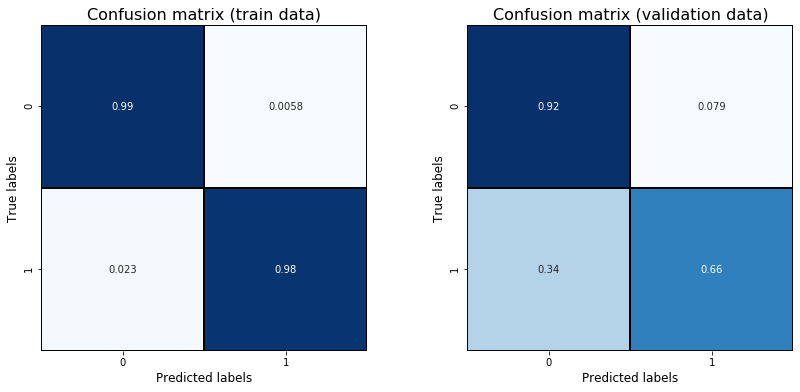

In [29]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1, 
                      title='Confusion matrix (train data)')
plot_confusion_matrix(y_val, y_val_pred, ax=axis2, 
                      title='Confusion matrix (validation data)')

In [114]:
from sklearn.metrics import classification_report, accuracy_score

print('Classification report on Test set: \n', classification_report(y_val, y_val_pred))

Classification report on Test set: 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       886
           1       0.86      0.66      0.75       637

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



In [116]:
y_val_probs = logistic.predict_proba(val_data_features.sign())[:, 1]

for thresh in np.arange(0.3, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    print("Accuracy score at threshold {0} is {1}".format(thresh, accuracy_score(y_val, (y_val_probs>thresh).astype(int))))

Accuracy score at threshold 0.3 is 0.7747866053841103
Accuracy score at threshold 0.31 is 0.7754432042022325
Accuracy score at threshold 0.32 is 0.7820091923834537
Accuracy score at threshold 0.33 is 0.788575180564675
Accuracy score at threshold 0.34 is 0.7957977675640184
Accuracy score at threshold 0.35 is 0.7971109652002626
Accuracy score at threshold 0.36 is 0.7997373604727511
Accuracy score at threshold 0.37 is 0.8023637557452397
Accuracy score at threshold 0.38 is 0.8003939592908733
Accuracy score at threshold 0.39 is 0.8036769533814839
Accuracy score at threshold 0.4 is 0.8056467498358503
Accuracy score at threshold 0.41 is 0.8063033486539725
Accuracy score at threshold 0.42 is 0.8128693368351937
Accuracy score at threshold 0.43 is 0.8122127380170716
Accuracy score at threshold 0.44 is 0.81483913328956
Accuracy score at threshold 0.45 is 0.8181221273801708
Accuracy score at threshold 0.46 is 0.814182534471438
Accuracy score at threshold 0.47 is 0.8128693368351937
Accuracy score a

The highest accuracy score was achieved was at the threshold of approx. 0.45, i.e., if the probability of a tweet being a disaster tweet is above 0.45, it should be classified as 1.

<h2>TFIDF</h2>

Term-frequency inverse document frequency.  I have described this in detail in many places before. Logic will tell you that the binariezed version will give exactly the same results as BOW so let's just quickly run through regular logistic regression and random forest even though we don't expect either to perform as well as the binarized logistic regression model above

<b>Train the TFIDF model</b>

Once again we'll use unigrams and bigrams

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2))
train_data_features = tfidf.fit_transform(X_train)
val_data_features = tfidf.transform(X_val)

In [33]:
vocab = tfidf.get_feature_names()
print(vocab[:10])

['aa', 'aa ayyo', 'aa batteries', 'aaaa', 'aaaa ok', 'aaaaaand', 'aaaaaand thunder', 'aal', 'aar', 'aar ambulance']


<h2>Logistic Regression</h2>

In [34]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(C=0.5)
logistic.fit(train_data_features, y_train)
y_val_preds = logistic.predict(val_data_features)
(y_val_preds==y_val).mean()

0.7964543663821405

In [35]:
import eli5

eli5.show_weights(logistic, vec=tfidf, top=25)

Weight?,Feature
+2.146,hiroshima
+2.103,california
+1.908,fires
+1.752,fire
+1.704,killed
+1.614,suicide
+1.484,police
+1.461,bombing
+1.418,train
+1.380,mh


<h2>NBSVM</h2>

In [36]:
x = train_data_features
y = y_train.values

r = np.log(pr(1)/pr(0))
x_nb = x.multiply(r)

logistic = LogisticRegression(C=0.5)
logistic.fit(x_nb, y);

val_x_nb = val_data_features.multiply(r)
y_val_preds = logistic.predict(val_x_nb)
(y_val_preds.T==y_val.values).mean()

0.7747866053841103

In [37]:
eli5.show_weights(logistic, vec=tfidf, top=25)

Weight?,Feature
+2.858,hiroshima
+2.368,california
+2.294,fires
+2.277,killed
+1.801,fire
+1.765,earthquake
+1.761,typhoon
+1.759,police
+1.708,train
+1.700,derailment


<h2>Random Forest Classifier</h2>

In [38]:
forest = RandomForestClassifier(n_estimators = 200)
forest = forest.fit(train_data_features, y_train)

In [39]:
# Predict on training set
y_train_pred = forest.predict(train_data_features)

# Predict on validation set
y_val_pred = forest.predict(val_data_features)

In [40]:
(y_val_pred == y_val).mean()

0.7971109652002626

<h2>Final thoughts on the baseline model</h2>

There we go. We got the best performance out of binarized logistic regression with an accuracy of ~82.2% on the validation set. This is definitely not a bad start, but we should be able to improve on this. In the next few notebooks I'll use word embeddings using GloVe and FastText and eventually will move on to deep learning models using LSTM!

<h2>Submission set</h2>

Make predictions on the submission set using binarized logistic regression

In [43]:
test = pd.read_csv('data/test_cleaned.csv')

test.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


In [45]:
test['clean_text']

0                             happened terrible car crash
1       heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                     typhoon soudelor kills china taiwan
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm ri worse last hurricane city others hard...
3260                        green line derailment chicago
3261             meg issues hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: clean_text, Length: 3263, dtype: object

In [76]:
from sklearn.feature_extraction.text import CountVectorizer

train_data_features = bv.fit_transform(X_train)
test['clean_text'] = test['clean_text'].apply(lambda x: str(x))
test_data_features = bv.transform(test['clean_text'])

In [77]:
logistic = LogisticRegression(C=0.5)
logistic.fit(train_data_features.sign(), y_train)
y_test_pred = logistic.predict(test_data_features.sign())

In [84]:
y_test_probs = logistic.predict_proba(test_data_features.sign())[:, 1]

In [87]:
(y_test_probs>0.45).sum()/3262

0.35898221949724096

According to the Logistic Regression model, 36% of tweets in the test set are classified as disaster tweets

In [110]:
test['target'] = y_test_pred
test.head()

,id,keyword,location,text,clean_text,target
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,1


In [113]:
test[['id', 'target']].to_csv('data/submission.csv', index=False)